In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
import sklearn.neural_network
import sklearn.svm
import sklearn.naive_bayes
import sklearn.tree
import lime.lime_tabular_mod
import matplotlib.pyplot as plt
import doc.mod.utils.DatasetRepository as dr
from tqdm import tqdm

import importlib
importlib.reload(lime.lime_tabular_mod)
repo = dr.DatasetRepository("../data")


pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load dataset: Fetal Health

In [2]:
dataset = repo.get_fetal_health_dataset()
dataset.train_data

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
593,120.0,0.004,0.010,0.004,0.000,0.0,0.000,37.0,1.5,0.0,11.3,96.0,78.0,174.0,4.0,0.0,119.0,132.0,128.0,51.0,0.0
1233,125.0,0.000,0.000,0.008,0.000,0.0,0.000,32.0,1.1,3.0,13.0,51.0,96.0,147.0,4.0,0.0,126.0,125.0,127.0,2.0,0.0
216,127.0,0.000,0.005,0.000,0.000,0.0,0.000,63.0,0.5,4.0,11.3,89.0,62.0,151.0,4.0,0.0,129.0,128.0,130.0,1.0,1.0
15,130.0,0.006,0.380,0.004,0.004,0.0,0.001,19.0,2.3,0.0,8.7,107.0,67.0,174.0,3.0,0.0,134.0,127.0,133.0,43.0,0.0
602,144.0,0.010,0.007,0.001,0.001,0.0,0.000,71.0,0.8,0.0,2.7,94.0,82.0,176.0,3.0,0.0,156.0,154.0,155.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,133.0,0.008,0.000,0.004,0.006,0.0,0.000,16.0,2.6,0.0,0.0,98.0,82.0,180.0,5.0,0.0,131.0,138.0,136.0,54.0,0.0
713,120.0,0.008,0.000,0.005,0.000,0.0,0.000,43.0,1.4,5.0,18.4,106.0,50.0,156.0,8.0,0.0,129.0,129.0,130.0,11.0,1.0
1746,134.0,0.009,0.000,0.010,0.005,0.0,0.000,57.0,1.2,0.0,0.0,101.0,86.0,187.0,3.0,0.0,151.0,148.0,155.0,47.0,1.0
2090,133.0,0.000,0.001,0.005,0.000,0.0,0.000,78.0,0.8,44.0,3.6,14.0,130.0,144.0,1.0,0.0,136.0,134.0,137.0,0.0,0.0


## Check performance of different classifiers on selected dataset (with their default settings)

In [3]:
models = [
    ("Random Forest", sklearn.ensemble.RandomForestClassifier(n_jobs=-1)),
    ("AdaBoost", sklearn.ensemble.AdaBoostClassifier()),
    ("DecisionTree", sklearn.tree.DecisionTreeClassifier()),
    ("Neural Network", sklearn.neural_network.MLPClassifier()),
    ("SVM", sklearn.svm.LinearSVC()),
    ("Naive Bayes", sklearn.naive_bayes.GaussianNB()),
    ("kNN", sklearn.neighbors.KNeighborsClassifier())
]
precision_for_classifier = {}
recall_for_classifier = {}
f1_for_classifier = {}
for (classifier_name, model) in models:
    x = dataset.train_data.to_numpy()
    y = dataset.train_labels.to_numpy()
    model.fit(x, y)

    x = dataset.test_data.to_numpy()
    y_true = dataset.test_labels.to_numpy()
    y_predicted = model.predict(x)

    precision_for_classifier[classifier_name] = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_predicted, average="macro")
    recall_for_classifier[classifier_name] = sklearn.metrics.recall_score(y_true=y_true, y_pred=y_predicted, average="macro")
    f1_for_classifier[classifier_name] = sklearn.metrics.f1_score(y_true=y_true, y_pred=y_predicted, average="macro")

c:\users\kamil zych\documents\mgr\lime\venv\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


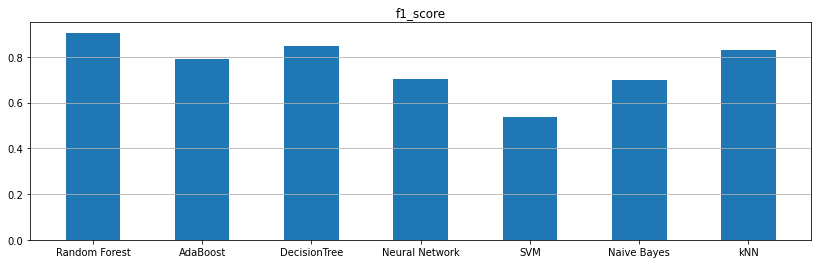

In [4]:
plt.figure(figsize=(14,4))
plt.bar(f1_for_classifier.keys(), f1_for_classifier.values(), width=0.5)
plt.title("f1_score")
plt.grid(axis="y")
plt.show()

## Use LIME to explain prediction
### Create explainer object
At first create explainer object that makes use of training data.
It may be used by discretizer inner object and enhance local surrogate's performance.

In [5]:
explainer = lime.lime_tabular_mod.LimeTabularExplainerMod(
    dataset.train_data.to_numpy(),
    feature_names = dataset.train_data.columns.to_list(),
    class_names = dataset.train_labels.drop_duplicates().to_list(), # should be equal to model.classes_
    discretize_continuous=False,
    sample_around_instance=True,
    categorical_features=dataset.categorical_features
)

In [6]:
test_data_subset = dataset.test_data.to_numpy()

labels_count = 3
quantiles_count = 50
test_instances_count = test_data_subset.shape[0]

scores_for_surrogate_model = np.empty(shape=(test_instances_count, labels_count), dtype="float32")
losses_for_surrogate_model = np.empty(shape=(test_instances_count, labels_count), dtype="float32")
fidelity_loss_on_explanation = np.empty(shape=(test_instances_count,), dtype="float32")
fidelity_loss_on_generated_data = np.empty(shape=(test_instances_count,), dtype="float32")
fidelity_loss_distribution_quantiles = np.empty(shape=(test_instances_count, quantiles_count), dtype="float32")

for idx, test_instance in enumerate(tqdm(test_data_subset)):
    explanation = explainer.explain_instance(
        test_instance.reshape(-1),
        model.predict_proba,
        num_features = 4,
        top_labels = labels_count,
        distance_metric="minkowski",
        minkowski_norm=100.
    )
    scores_for_surrogate_model[idx, :] = explanation.get_scores_for_surrogate_model()
    losses_for_surrogate_model[idx, :] = explanation.get_losses_for_surrogate_model()
    fidelity_loss_on_explanation[idx] = explanation.get_fidelity_loss_on_explanation()
    fidelity_loss_on_generated_data[idx] = explanation.get_fidelity_loss_on_generated_data()
    fidelity_loss_distribution_quantiles[idx, :] = explanation.get_fidelity_loss_distribution(quantiles=quantiles_count)

100%|██████████| 426/426 [04:30<00:00,  1.58it/s]


label #0 mean score: 0.2959223687648773
label #1 mean score: 0.2333185225725174
label #2 mean score: 0.17784550786018372


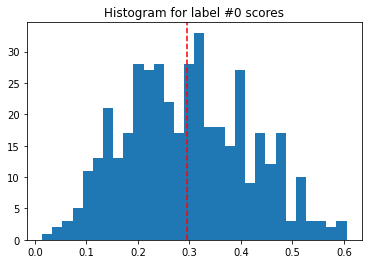

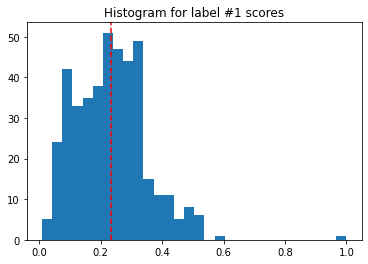

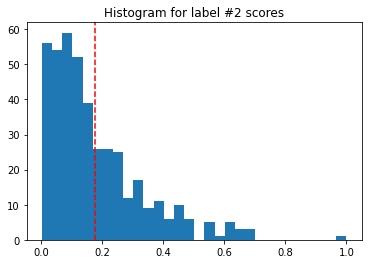

In [7]:
for idx in range(labels_count):
    mean_score = np.mean(scores_for_surrogate_model[:, idx])
    print(f"label #{idx} mean score: {mean_score}", flush=True)
    plt.hist(scores_for_surrogate_model[:, idx], bins=30)
    plt.axvline(mean_score, color="red", linestyle="--")
    plt.title(f"Histogram for label #{idx} scores")
    plt.show()

label #0 mean loss: 0.03750890493392944
label #1 mean loss: 0.0308552049100399
label #2 mean loss: 0.01463326159864664


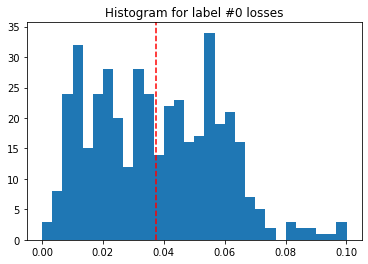

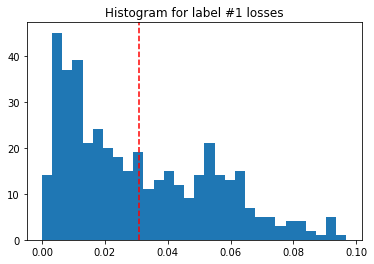

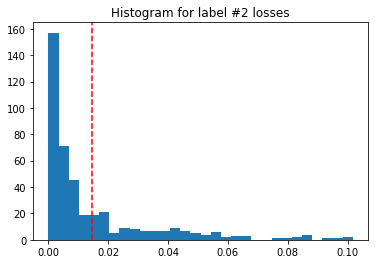

In [8]:
for idx in range(labels_count):
    mean_loss = np.mean(losses_for_surrogate_model[:, idx])
    print(f"label #{idx} mean loss: {mean_loss}")
    plt.hist(losses_for_surrogate_model[:, idx], bins=30)
    plt.axvline(mean_loss, color="red", linestyle="--")
    plt.title(f"Histogram for label #{idx} losses")
    plt.show()

Mean fidelity loss on explanation: 0.10129614919424057


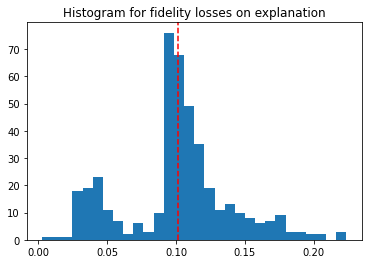

In [9]:
mean_fidelity_loss_on_explanation = np.mean(fidelity_loss_on_explanation)
print(f"Mean fidelity loss on explanation: {mean_fidelity_loss_on_explanation}")
plt.hist(fidelity_loss_on_explanation, bins=30)
plt.axvline(mean_fidelity_loss_on_explanation, color="red", linestyle="--")
plt.title(f"Histogram for fidelity losses on explanation")
plt.show()

Mean fidelity loss on generated data: 0.08466550707817078


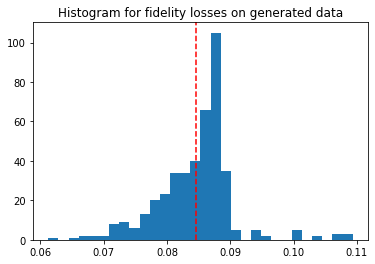

In [10]:
mean_fidelity_loss_on_generated_data = np.mean(fidelity_loss_on_generated_data)
print(f"Mean fidelity loss on generated data: {mean_fidelity_loss_on_generated_data}")
plt.hist(fidelity_loss_on_generated_data, bins=30)
plt.axvline(mean_fidelity_loss_on_generated_data, color="red", linestyle="--")
plt.title(f"Histogram for fidelity losses on generated data")
plt.show()

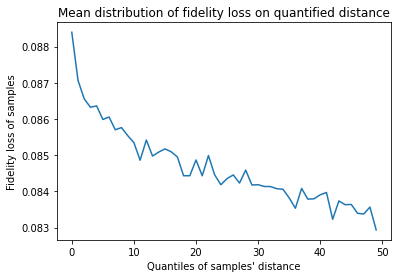

In [11]:
plt.plot(np.mean(fidelity_loss_distribution_quantiles, axis=0))
plt.ylabel(f"Fidelity loss of samples")
plt.xlabel(f"Quantiles of samples' distance")
plt.title(f"Mean distribution of fidelity loss on quantified distance")
plt.show()